## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Изуткина Александра

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 17 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

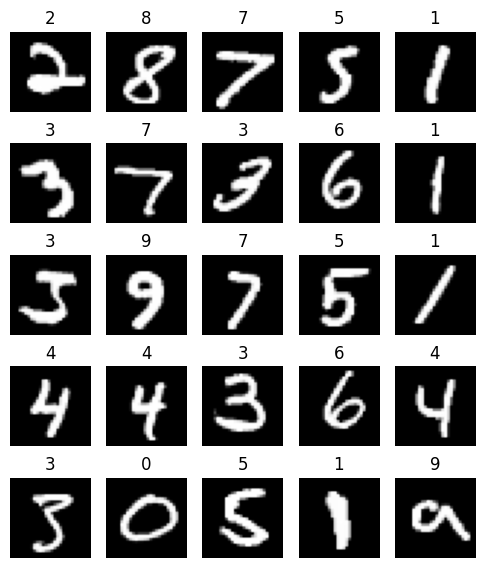

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [5]:
def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [13]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9972631335258484
forward 17.002914428710938
backward 0.029814239591360092
backward 0.19077762961387634


#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

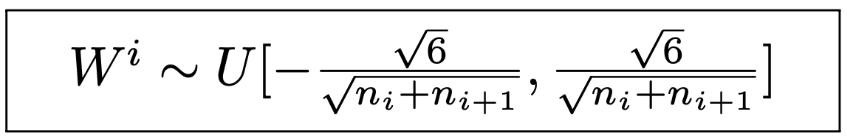

## Xavier

In [8]:
def Xavier(layer, a):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(-a,a)

layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)
layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)
layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

Xavier(layer_1,(6**(1/2))/((28*28+500)**(1/2)))
Xavier(layer_2,(6**(1/2))/((10+500)**(1/2)))

network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9972631335258484
forward 0.6470077037811279
backward 0.029814239591360092
backward 0.012219960801303387


## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

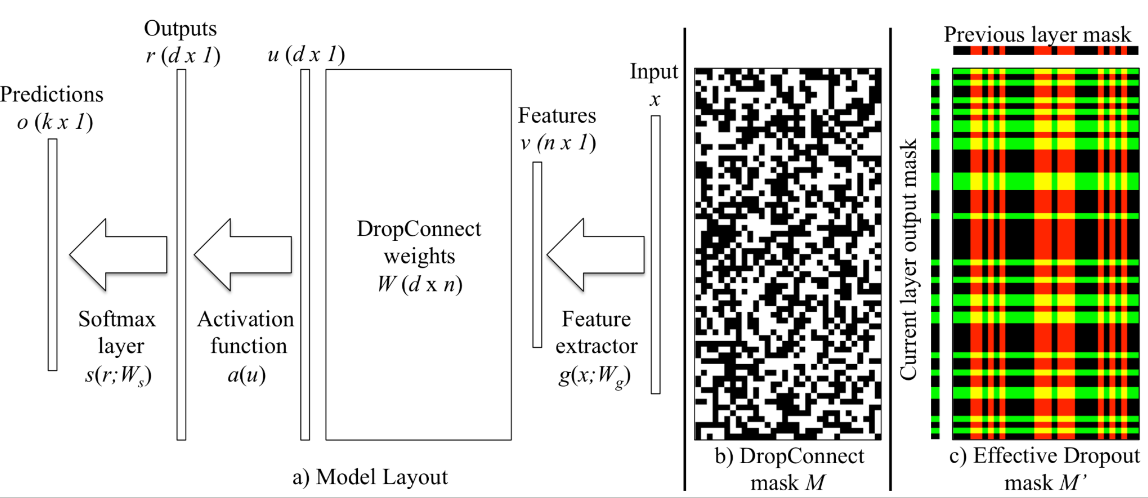

In [7]:
def train(network,train_loader,test_loader,loss_fn,optimizer):
    losseses = []
    for epoch in range(10):
        network.train()
        for batch_idx, (images_train, labels_train) in enumerate(train_loader):
            optimizer.zero_grad()
            X = images_train.data
            y = labels_train.data
            output = network(X)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
    
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
        network.eval()
        losses=[]
        for batch_idx, (images_test, labels_test) in enumerate(test_loader):
            X = images_test.data
            y = labels_test.data
            output = network(X)
            loss = loss_fn(output, y)
            losses.append(loss.item())
    
        print('Test Epoch: {}\tLoss: {:.6f}'.format(
                epoch, np.mean(losses)))
        losseses.append(np.mean(losses))
    return losseses


In [15]:
class Dropout(nn.Module):
    def __init__(self, p=0.2):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        return x * mask

## DropConnect

In [13]:

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.2):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.bernoulli(torch.ones(self.linear.weight.shape) * (1 - self.p))
            mask.requires_grad = False 
        else:
            mask = torch.ones(self.linear.weight.shape)
            mask.requires_grad = False 

        
        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

In [10]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()
        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        self.final_part = final_part
        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


In [16]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 10)
]
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()
loss1=train(network,train_loader,test_loader,loss_fn,optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.313307
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.768895
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.333655
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.349274
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.267687
Test Epoch: 0	Loss: 0.172306
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.213393
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.171431
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.152754
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.297179
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.223857
Test Epoch: 1	Loss: 0.122185
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.100471
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.091963
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.110072
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.152699
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.143619
Test Epoch: 2	Loss: 0.083151
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.094168
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.057399
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.197904
Train Epoch: 3 [38400/60000 (64%)

In [14]:
layersDC = [
    DropConnect(196,128),
    nn.ReLU(),
    DropConnect(128,128),
    nn.ReLU(),
    DropConnect(128,10)
]
network = TestNetwork(nn.Sequential(*layersDC))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()
loss2=train(network,train_loader,test_loader,loss_fn,optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.295865
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.643791
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.308235
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.343816
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.322182
Test Epoch: 0	Loss: 0.262831
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.248966
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.267166
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.166249
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.142659
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.248996
Test Epoch: 1	Loss: 0.157899
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.175347
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.195548
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.244352
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.154282
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.091499
Test Epoch: 2	Loss: 0.145550
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.175073
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.052568
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.109693
Train Epoch: 3 [38400/60000 (64%)

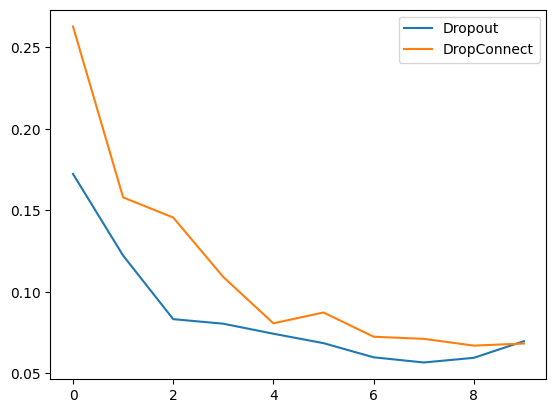

In [17]:
plt.plot(loss1, label='Dropout')
plt.plot(loss2, label='DropConnect')
plt.legend()
plt.show()

Обе нейросети показали снижение ошибки в результате обучения. График снижения ошибки сети c Dropout оказался глаже, но итоговая ошибка после 10 эпох оказалась почти одинаковой

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

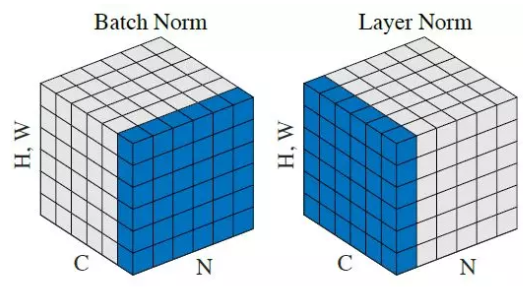

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

## LayerNormalization

In [40]:
class LayerNormalization(nn.Module):
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        output = (x - mean) / (std + 1e-7)
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [49]:
layers = [
    nn.Linear(196, 128),
    LayerNormalization(),
    nn.ReLU(),
    nn.Linear(128, 128),
    LayerNormalization(),
    nn.ReLU(),
    nn.Linear(128, 10)
]
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()
loss1=train(network,train_loader,test_loader,loss_fn,optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.331215
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.403609
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.301682
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.206984
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.185042
Test Epoch: 0	Loss: 0.163445
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.108672
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.149461
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.103511
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.136068
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.105624
Test Epoch: 1	Loss: 0.124064
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.108305
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.156893
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.037811
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.087267
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.060406
Test Epoch: 2	Loss: 0.087495
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.057719
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.128586
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.063615
Train Epoch: 3 [38400/60000 (64%)

In [48]:
layers = [
    nn.Linear(196, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 10)
]
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()
loss2=train(network,train_loader,test_loader,loss_fn,optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.324283
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.321059
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.223293
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.072524
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.067204
Test Epoch: 0	Loss: 0.100286
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.130212
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.081154
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.065348
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.104881
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.068643
Test Epoch: 1	Loss: 0.068989
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.085287
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.086241
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.036932
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.092778
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.110051
Test Epoch: 2	Loss: 0.077824
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.034787
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.026304
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.070248
Train Epoch: 3 [38400/60000 (64%)

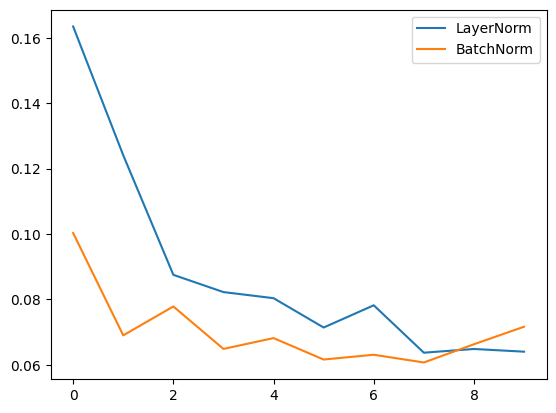

In [50]:
plt.plot(loss1, label='LayerNorm')
plt.plot(loss2, label='BatchNorm')
plt.legend()
plt.show()

Графики обучения показывают снижение величины ошибки, хоть и не совсем стабильное. В результате проведенного обучения, нейросеть с LayerNormalization показала меньшее значение ошибки, чем BatchNorm.